# Linear Regression

This project is for making a linear regression model for joint angle prediction

In [3]:
# Imports
from pathlib import Path
import os
import pickle
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from dataclasses import dataclass
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample, decimate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
)
from sklearn.decomposition import PCA

The dataset needs to be restructured for linear regression.
We don't need the gesture labels anymore, since our target is just joint angles.
We need to window the joint angles too. For simplicity we will average the 200ms window of joint angle data.

# Dataset export to get glove kinematic target values

In [15]:
"""
Features (from SEED dataset)
"""

def MAV(data):
    """
    :param data: 2D array, channels x samples
    :return: MAV of the data
    """
    return np.mean(np.abs(data), axis=1).reshape((1, data.shape[0]))

def VAR(data):
    """
    Variance
    :param data: 2D array, channels x samples
    :return: Variance of the data
    """
    return np.var(data, axis=1).reshape((1, data.shape[0]))

def RMS(data):
    """
    Root mean square
    :param data: 2D array, channels x samples
    :return: RMS per channel
    """
    return np.sqrt(np.mean(data**2, axis=1)).reshape((1, data.shape[0]))

def zero_crossings(data):
    """
    Number of zero crossings from each channel
    :param data: 2D array, channels x samples
    :return: number of zero crossings for each channel
    """
    positive = data > 0
    return np.sum(np.bitwise_xor(positive[:, 1:], positive[:, :-1]), axis=1).reshape((1, data.shape[0]))

def avg_amplitude_change(data):
    """
    https://www.sciencedirect.com/science/article/pii/S0957417412001200
    :param data: 2D array, channels x samples
    :return: Average amplitude change (AAC) as defined in the reference above
    """
    return np.mean(np.abs(np.diff(data, axis=1)), axis=1).reshape((1, data.shape[0]))

"""Additional frequency domain features"""

def spectral_centroid(data):
    """
    Spectral Centroid
    :param data: 2D array, channels x samples
    :return: Spectral centroid per channel (FFT-bin based)
    """
    # Magnitude spectrum
    spectrum = np.abs(np.fft.rfft(data, axis=1))
    
    # Frequency bin indices
    freqs = np.arange(spectrum.shape[1])
    
    # Avoid division by zero
    denom = np.sum(spectrum, axis=1) + 1e-12
    
    centroid = np.sum(spectrum * freqs, axis=1) / denom
    return centroid.reshape((1, data.shape[0]))


def spectral_spread(data):
    """
    Spectral Spread
    :param data: 2D array, channels x samples
    :return: Spectral spread per channel (FFT-bin based)
    """
    # Magnitude spectrum
    spectrum = np.abs(np.fft.rfft(data, axis=1))
    
    # Frequency bin indices
    freqs = np.arange(spectrum.shape[1])
    
    # Avoid division by zero
    denom = np.sum(spectrum, axis=1) + 1e-12
    
    # Spectral centroid
    centroid = np.sum(spectrum * freqs, axis=1) / denom
    
    # Spectral spread (standard deviation around centroid)
    spread = np.sqrt(
        np.sum(spectrum * (freqs - centroid[:, None])**2, axis=1) / denom
    )
    
    return spread.reshape((1, data.shape[0]))

In [26]:
import math
import copy
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import resample, decimate
import os

"""
Create a dataset for classification training/testing.
Each participant is stored in a separate file.
"""

def extract_windows_glove(data, num_windows, window_size, window_step):
    windows = []
    for i in range(num_windows):
        start = int(i*window_step)
        end = int(start + window_size)
        win_data = data[:, start:end]
        win_data = np.mean(win_data, axis=1)
        windows.append(win_data)
    return np.array(windows)

def extract_windows(data, num_windows, window_size, window_step):
    windows = []
    for i in range(num_windows):
        start = int(i*window_step)
        end = int(start + window_size)
        win_data = data[:, start:end]
        windows.append(win_data)
    return windows

def num_windows(length, window_size, window_step):
    return int(math.floor((length - window_size) / window_step)) + 1

def extract_features_by_window(data, num_windows, window_size, window_step):
    """
    Splits data set into windows, extracts features for each window
    """

    feature_names = ['mav', 'var', 'rms', 'zcr', 'aac', 'sc', 'ss']

    windows = []
    for i in range(num_windows):
        start = int(i*window_step)
        end = int(start + window_size)
        win_data = data[:, start:end]

        feature_array = []
        feature_array.append(MAV(win_data))
        feature_array.append(VAR(win_data))
        feature_array.append(RMS(win_data))
        feature_array.append(zero_crossings(win_data))
        feature_array.append(avg_amplitude_change(win_data))
        feature_array.append(spectral_centroid(win_data))
        feature_array.append(spectral_spread(win_data))
        
        windows.append(feature_array)
    return windows, feature_names


# file handling
ROOT = Path.cwd()
LABELS = ROOT / 'labels'
DATA = ROOT / 'pkl_dataset_resampled'

# windowing
FS = 512
WINDOW_SIZE = int(0.2*FS)   # 200 ms windows
WINDOW_HOP = WINDOW_SIZE // 2 # 50% overlap (NOTE: WINDOW_HOP = WINDOW_SIZE - WINDOW_OVERLAP)

## Load labels data
labels = pd.read_csv(LABELS / 'labels.csv', index_col=False)
kill_list = pd.read_csv(LABELS / 'kill_list.csv', index_col=False)
kill_list = kill_list['file'].to_list()

## Create empty data frame for all data
dataset_columns = {'movement': [], 'joints': [], 'speed': [], 'subject': [], 'session': [], 'trial': [], 'windows_raw': [], 'windows_feature': []}
df = pd.DataFrame(dataset_columns)

## Load in dataset
dirs = [entry.name for entry in os.scandir(DATA) if entry.is_dir()]
for dir in dirs:
    files = [x for x in os.listdir(DATA / dir) if '.pkl' in x]
    for file in files:
        # load data file
        temp = pd.read_pickle(DATA / dir / file)

        if temp['movement'] == 'disc' or temp['movement'] == 'thumbAdd' or temp['movement'] == 'middle' or temp['movement'] == 'index' or file in kill_list:
            continue

        temp_row = dataset_columns.copy()

        # get labels
        file_labs = labels.loc[labels['file'] == file].to_dict(orient='records') # note if this returns more than 1 row something is wrong
        # print(file_labs)
        try:
            file_labs = file_labs[0]
            try:
                start_sample = int(file_labs['start'] * FS)
                end_sample = int(file_labs['end'] * FS)
                # print(f"Start time: {start_sample / FS} | End time: {end_sample / FS}")
            except:
                raise ValueError(f'Could not access start')
        except:
                print(f"Could not find labels for file {file}")
                print(f"Movement: {temp['movement']} | Speed: {temp['speed']}")
        
        if end_sample < start_sample:
            print(f"Start time was less than end time for file {file}")
            print(f"Start time: {start_sample / FS} | End time: {end_sample / FS}")
            print("Continuing to next file")
            continue

        emg = temp['emg']
        joints = temp['glove']

        # extract windows
        n_windows = num_windows(emg.shape[1], WINDOW_SIZE, WINDOW_HOP)
        windows = extract_windows(emg, n_windows, WINDOW_SIZE, WINDOW_HOP)
        joints = extract_windows_glove(joints, n_windows, WINDOW_SIZE, WINDOW_HOP)
        feature_windows, feature_names = extract_features_by_window(emg, n_windows, WINDOW_SIZE, WINDOW_HOP)

        ## append data to dataframe
        temp_row['windows_raw'] = windows
        temp_row['windows_feature'] = feature_windows
        temp_row['joints'] = joints
        temp_row['speed'] = str(temp['speed'][0])
        temp_row['subject'] = str(temp['subject'][0])
        temp_row['movement'] = str(temp['movement'][0])
        temp_row['session'] = int(temp['session'][0][0])
        temp_row['trial'] = int(str(file).split('.')[0].split('_')[-1])

        df_the_dict = pd.DataFrame([temp_row])
        df = pd.concat([df, df_the_dict], ignore_index=True)

Could not find labels for file detop_exp01_subj02_Sess3_02_02.pkl
Movement: ['index_flex'] | Speed: ['fast']
Could not find labels for file detop_exp01_subj03_Sess3_07_04.pkl
Movement: ['cilinder'] | Speed: ['fast']
Could not find labels for file detop_exp01_subj04_Sess2_11_02.pkl
Movement: ['pinch'] | Speed: ['slow']
Could not find labels for file detop_exp01_subj04_Sess1_03_05.pkl
Movement: ['point'] | Speed: ['slow']
Could not find labels for file detop_exp01_subj04_Sess1_05_06.pkl
Movement: ['3digit'] | Speed: ['fast']
Start time was less than end time for file detop_exp01_subj04_Sess1_05_01.pkl
Start time: 1.8515625 | End time: 0.6796875
Continuing to next file
Start time was less than end time for file detop_exp01_subj10_Sess1_13_04.pkl
Start time: 0.58984375 | End time: 0.0
Continuing to next file
Start time was less than end time for file detop_exp01_subj08_Sess2_08_05.pkl
Start time: 4.17578125 | End time: 0.296875
Continuing to next file
Could not find labels for file detop_e

In [ ]:
df.to_pickle('dataset_regression.pkl')

# Joint angle regression starts here

In [4]:
### Joint angles regression

import numpy as np

def reshape_data_windows_regression(X, y):
    """
    Converts:
        X: recordings x windows x features x channels
        y: recordings x windows x output_channels

    To:
        X_out: total_windows x (features * channels)
        y_out: total_windows x output_channels
    """

    X_list = list(X)
    y_list = list(y)

    X_windows = []
    y_windows = []

    for rec_idx, (rec_X, rec_y) in enumerate(zip(X_list, y_list)):
        rec_X = np.asarray(rec_X)
        rec_y = np.asarray(rec_y)

        # Skip recordings with no windows
        if rec_X.shape[0] == 0:
            continue

        # Sanity check
        if rec_X.shape[0] != rec_y.shape[0]:
            raise ValueError(
                f"Window mismatch in recording {rec_idx}: "
                f"X has {rec_X.shape[0]}, y has {rec_y.shape[0]}"
            )

        for w in range(rec_X.shape[0]):
            # Flatten features x channels → 938
            X_windows.append(rec_X[w].reshape(-1))
            y_windows.append(rec_y[w])  # shape: (18,)

    X_out = np.asarray(X_windows)
    y_out = np.asarray(y_windows)

    return X_out, y_out


dataset = pd.read_pickle('dataset_regression.pkl')

alpha: 1.832e-02   (1/10)
  Fold 1/10
    Val R²: -0.911
    Train R²: 0.123
  Fold 2/10
    Val R²: -13.695
    Train R²: 0.146
  Fold 3/10
    Val R²: -0.753
    Train R²: 0.128
  Fold 4/10
    Val R²: -0.155
    Train R²: 0.125
  Fold 5/10
    Val R²: -16.824
    Train R²: 0.150
  Fold 6/10
    Val R²: -2.225
    Train R²: 0.129
  Fold 7/10
    Val R²: -15.530
    Train R²: 0.136
  Fold 8/10
    Val R²: -14.038
    Train R²: 0.127
  Fold 9/10
    Val R²: -0.984
    Train R²: 0.126
  Fold 10/10
    Val R²: -8.810
    Train R²: 0.149
alpha: 4.455e-02   (2/10)
  Fold 1/10
    Val R²: -0.911
    Train R²: 0.123
  Fold 2/10
    Val R²: -13.695
    Train R²: 0.146
  Fold 3/10
    Val R²: -0.753
    Train R²: 0.128
  Fold 4/10
    Val R²: -0.155
    Train R²: 0.125
  Fold 5/10
    Val R²: -16.824
    Train R²: 0.150
  Fold 6/10
    Val R²: -2.225
    Train R²: 0.129
  Fold 7/10
    Val R²: -15.530
    Train R²: 0.136
  Fold 8/10
    Val R²: -14.038
    Train R²: 0.127
  Fold 9/10
    Val R

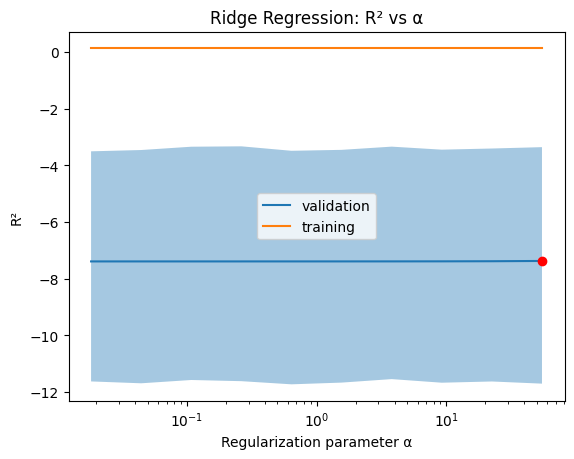

Optimal alpha: 5.460e+01
Best validation R²: -7.376


In [5]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.stats import bootstrap
import matplotlib.pyplot as plt
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# reshape
X_train, X_test, y_train, y_test = train_test_split(dataset['windows_feature'], dataset['joints'], test_size=0.2, random_state=42)
X_train, y_train = reshape_data_windows_regression(X_train, y_train)

# hyperparameters
n = 10
alphas = np.exp(np.linspace(-4, 4, n))  # literature-backed range

r2_val_arr = []
r2_train_arr = []
ci_lows = np.zeros(n)
ci_highs = np.zeros(n)

for j, alpha_j in enumerate(alphas):
    print(f'alpha: {alpha_j:.3e}   ({j+1}/{len(alphas)})')
    
    r2_val = []
    r2_train = []
    
    for i in range(10):  # 10-fold CV
        print(f'  Fold {i+1}/10')

        # 50/50 split
        X_train_i, X_val_i, y_train_i, y_val_i = train_test_split(
            X_train, y_train,
            test_size=0.5,
            shuffle=True,
            random_state=i
        )

        # PCA
        pca = PCA()
        X_train_i = pca.fit_transform(X_train_i)[:, :40]
        X_val_i   = pca.transform(X_val_i)[:, :40]

        # Scaling
        scaler = StandardScaler()
        X_train_i = scaler.fit_transform(X_train_i)
        X_val_i   = scaler.transform(X_val_i)

        # Ridge regression (multi-output by default)
        reg = Ridge(alpha=alpha_j)
        reg.fit(X_train_i, y_train_i)

        # Predictions
        y_val_pred = reg.predict(X_val_i)
        y_train_pred = reg.predict(X_train_i)

        # R² (average across outputs)
        r2_val.append(
            r2_score(y_val_i, y_val_pred, multioutput='uniform_average')
        )
        r2_train.append(
            r2_score(y_train_i, y_train_pred, multioutput='uniform_average')
        )

        print(f'    Val R²: {r2_val[-1]:.3f}')
        print(f'    Train R²: {r2_train[-1]:.3f}')

    # Store means
    r2_val_arr.append(np.mean(r2_val))
    r2_train_arr.append(np.mean(r2_train))

    # Confidence intervals (bootstrap)
    ci_lows[j], ci_highs[j] = bootstrap(
        (np.array(r2_val),),
        np.mean
    ).confidence_interval

best_idx = np.argmax(r2_val_arr)
best_alpha = alphas[best_idx]
best_r2 = r2_val_arr[best_idx]

plt.semilogx(alphas, r2_val_arr, label='validation')
plt.semilogx(alphas, r2_train_arr, label='training')
plt.plot(best_alpha, best_r2, 'ro')
plt.fill_between(alphas, ci_lows, ci_highs, alpha=0.4)
plt.legend()
plt.xlabel('Regularization parameter α')
plt.ylabel('R²')
plt.title('Ridge Regression: R² vs α')
plt.show()

print(f'Optimal alpha: {best_alpha:.3e}')
print(f'Best validation R²: {best_r2:.3f}')

